# Import

In [57]:
import os
import random
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
#lib for loading bar
from tqdm import tqdm
import seaborn as sns
from tensorflow.keras.utils import img_to_array

# DATAS & Manipulations

In [2]:
def get_random_doggo(directory="./Datas/Images",directory_annotation="./Datas/Annotation"):
    '''
    get a path to a random picture of dog

    input : path to the main folder containing race/pictures
    
    return : path to a doggo picture, path to the corresponding annotation
    '''
    subdirs = [os.path.join(directory, subdir) for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory, subdir))]
    if not subdirs:
        raise ValueError("ERROR : no race folder found")
    random_subdir = random.choice(subdirs)
    image_paths = [os.path.join(random_subdir, file) for file in os.listdir(random_subdir) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_paths:
        raise ValueError("ERROR : no picture found in race folder")
    random_image_path = random.choice(image_paths)

    random_image_annotation_path = os.path.join(directory_annotation,random_image_path.split("\\")[-2])
    random_image_annotation_path = os.path.join(random_image_annotation_path,random_image_path.split(".")[-2].split("\\")[-1])
    return random_image_path, random_image_annotation_path

FICHIER :  ./Datas/Images\n02097298-Scotch_terrier\n02097298_2500.jpg
ANNOTATION :  ./Datas/Annotation\n02097298-Scotch_terrier\n02097298_2500


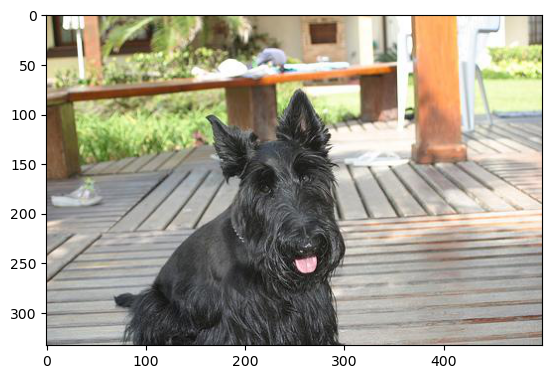

In [3]:
path_to_doggo, path_to_doggo_annotation = get_random_doggo()
print("FICHIER : " ,path_to_doggo)
print("ANNOTATION : " ,path_to_doggo_annotation)
random_dogo = Image.open(path_to_doggo)
plt.imshow(random_dogo)

# Récupération des labels

In [38]:
with open(path_to_doggo_annotation, 'r', encoding='utf-8') as fichier:
    contenu = fichier.read()

# Afficher le contenu du fichier
print(contenu)

<annotation>
	<folder>02097298</folder>
	<filename>n02097298_2500</filename>
	<source>
		<database>ImageNet database</database>
	</source>
	<size>
		<width>500</width>
		<height>333</height>
		<depth>3</depth>
	</size>
	<segment>0</segment>
	<object>
		<name>Scotch_terrier</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>70</xmin>
			<ymin>71</ymin>
			<xmax>304</xmax>
			<ymax>332</ymax>
		</bndbox>
	</object>
</annotation>


In [80]:
def extract_data_from_annotation(file_path, attributes= ['object/name','object/difficult']):
    tree = ET.parse(file_path)
    root = tree.getroot()

    data = {}

    for attr in attributes:
        elem = root.find(attr)
        if elem is not None:
            data[attr] = elem.text

    return data

In [111]:
a=extract_data_from_annotation(path_to_doggo_annotation)

In [112]:
a['object/name']

'Scotch_terrier'

# Short analysis

In [123]:
def get_dogs_datas(annotations_dir= "./Datas/Annotation"):
    """
    Parcourt les annotations pour en récupérer les datas que l'on souhaite analyser

    Args:
        annotations_dir (str): Chemin vers le répertoire contenant les annotations /breed/"annotations"

    Returns:
        pd.DataFrame: DataFrame contenant les données extraites des annotations.
    """
    data = []

    total_dirs = sum(1 for _ in os.walk(annotations_dir))

    with tqdm(total=total_dirs, desc="Processing directories") as pbar:
        for root, _, files in os.walk(annotations_dir):
            pbar.set_postfix(current_directory=root)

            for file in files:
                annotation_path = os.path.join(root, file)
                extracted_data = extract_data_from_annotation(annotation_path, attributes=[
                        'object/name',
                        'size/width',
                        'size/height',
                        'object/truncated',
                        'object/bndbox/xmin',
                        'object/bndbox/ymin',
                        'object/bndbox/xmax',
                        'object/bndbox/ymax'
                    ])
                row = [
                    annotation_path,
                    extracted_data['object/name'],
                    int(extracted_data['size/width']),
                    int(extracted_data['size/height']),
                    int(extracted_data['object/truncated']),
                    int(extracted_data['object/bndbox/xmin']),
                    int(extracted_data['object/bndbox/ymin']),
                    int(extracted_data['object/bndbox/xmax']),
                    int(extracted_data['object/bndbox/ymax']),
                ]
                data.append(row)
                
            pbar.update(1)
    return pd.DataFrame(data, columns=['file','breed','img_width','img_height','dog_trunc','xmin','ymin','xmax','ymax'])

data_analysis = get_dogs_datas()

Processing directories: 100%|██████████| 121/121 [00:05<00:00, 24.06it/s, current_directory=./Datas/Annotation\n02116738-African_hunting_dog]          


In [118]:
data_analysis.describe()

img_width    img_height  dog_trunc          xmin          ymin  \
count  20580.000000  20580.000000    20580.0  20580.000000  20580.000000   
mean     442.531876    385.861224        0.0     76.541011     56.541351   
std      142.792308    124.863446        0.0     75.279383     59.406210   
min       97.000000    100.000000        0.0      0.000000      0.000000   
25%      361.000000    333.000000        0.0     15.000000     13.000000   
50%      500.000000    375.000000        0.0     57.000000     39.000000   
75%      500.000000    453.000000        0.0    120.000000     82.000000   
max     3264.000000   2562.000000        0.0   1230.000000   1548.000000   

               xmax          ymax  
count  20580.000000  20580.000000  
mean     365.581681    354.171283  
std      129.140475    122.409322  
min       71.000000     90.000000  
25%      291.000000    289.000000  
50%      359.000000    339.000000  
75%      439.000000    399.000000  
max     2735.000000   2457.000000

## Breed datas

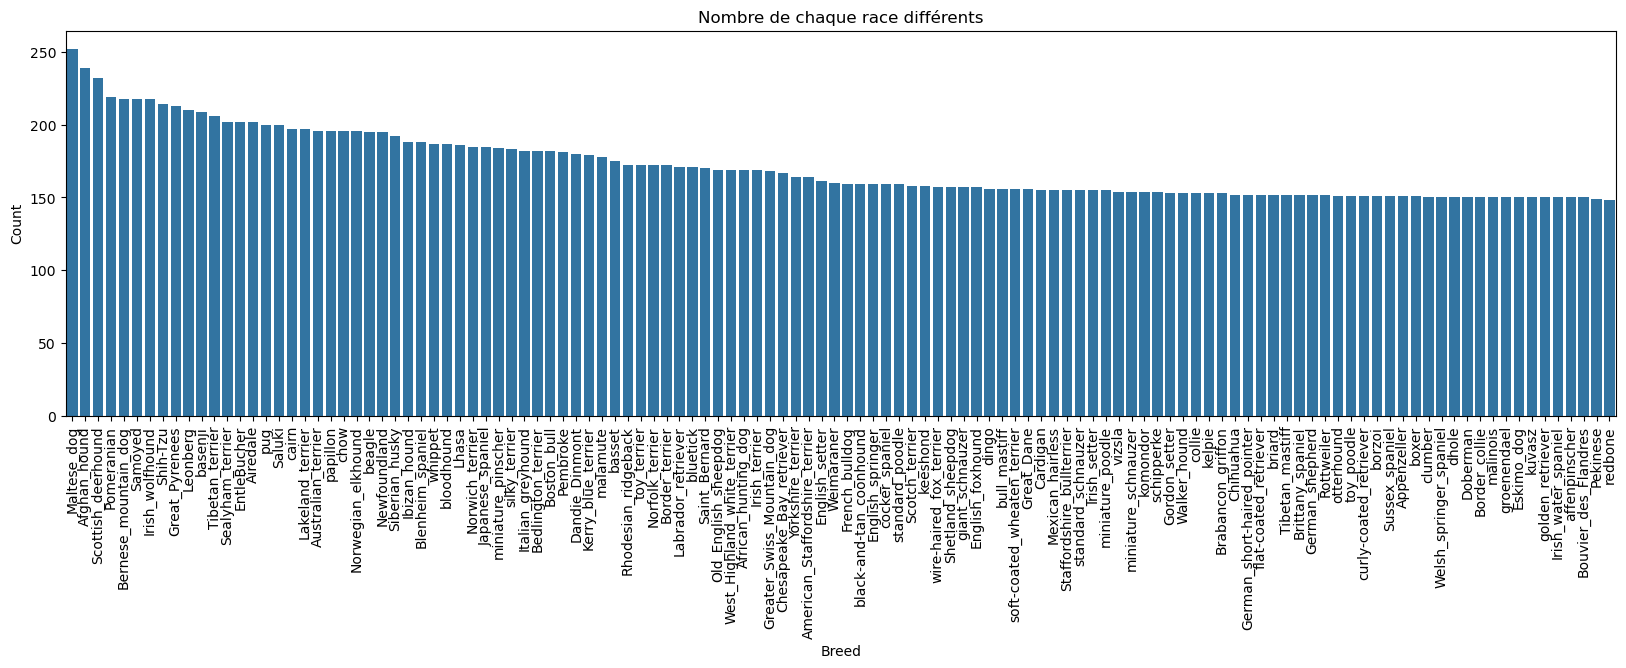

In [120]:
breed_counts = data_analysis['breed'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x=breed_counts.index, y=breed_counts.values)
plt.title('Nombre de chaque race différents')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

## picture analysis

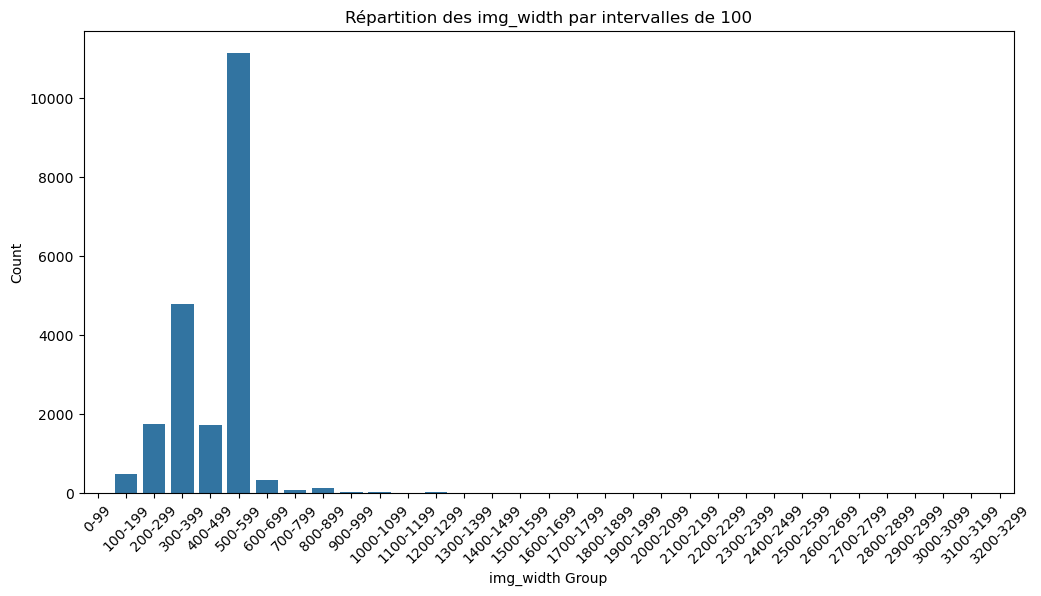

In [129]:
bin_size = 100

# Créer les bins
min_width = 0
max_width = data_analysis['img_width'].max()
bins = np.arange(min_width, max_width + bin_size, bin_size)
labels = [f'{b}-{b + bin_size - 1}' for b in bins[:-1]]

# Créer une nouvelle colonne pour les bins
data_analysis['width_group'] = pd.cut(data_analysis['img_width'], bins=bins, labels=labels, right=False)

# Comptage des occurrences pour chaque groupe
width_group_counts = data_analysis['width_group'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=width_group_counts.index, y=width_group_counts.values)
plt.title('Répartition des img_width par intervalles de 100')
plt.xlabel('img_width Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

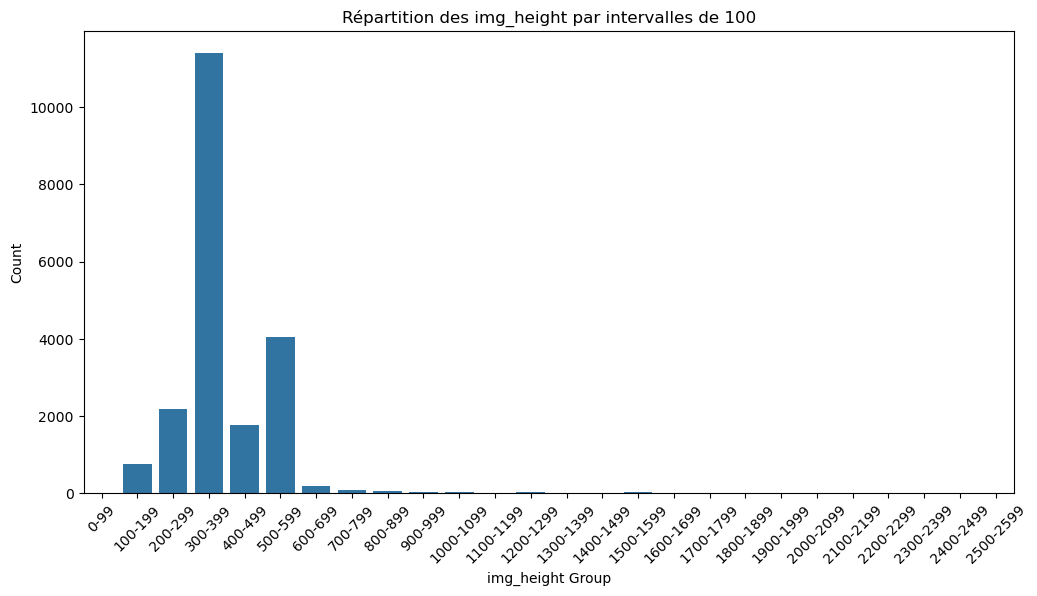

In [130]:
# Créer les bins
min_height = 0
max_height = data_analysis['img_height'].max()
bins = np.arange(min_height, max_height + bin_size, bin_size)
labels = [f'{b}-{b + bin_size - 1}' for b in bins[:-1]]

# Créer une nouvelle colonne pour les bins
data_analysis['height_group'] = pd.cut(data_analysis['img_height'], bins=bins, labels=labels, right=False)

# Comptage des occurrences pour chaque groupe
height_group_counts = data_analysis['height_group'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=height_group_counts.index, y=height_group_counts.values)
plt.title('Répartition des img_height par intervalles de 100')
plt.xlabel('img_height Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

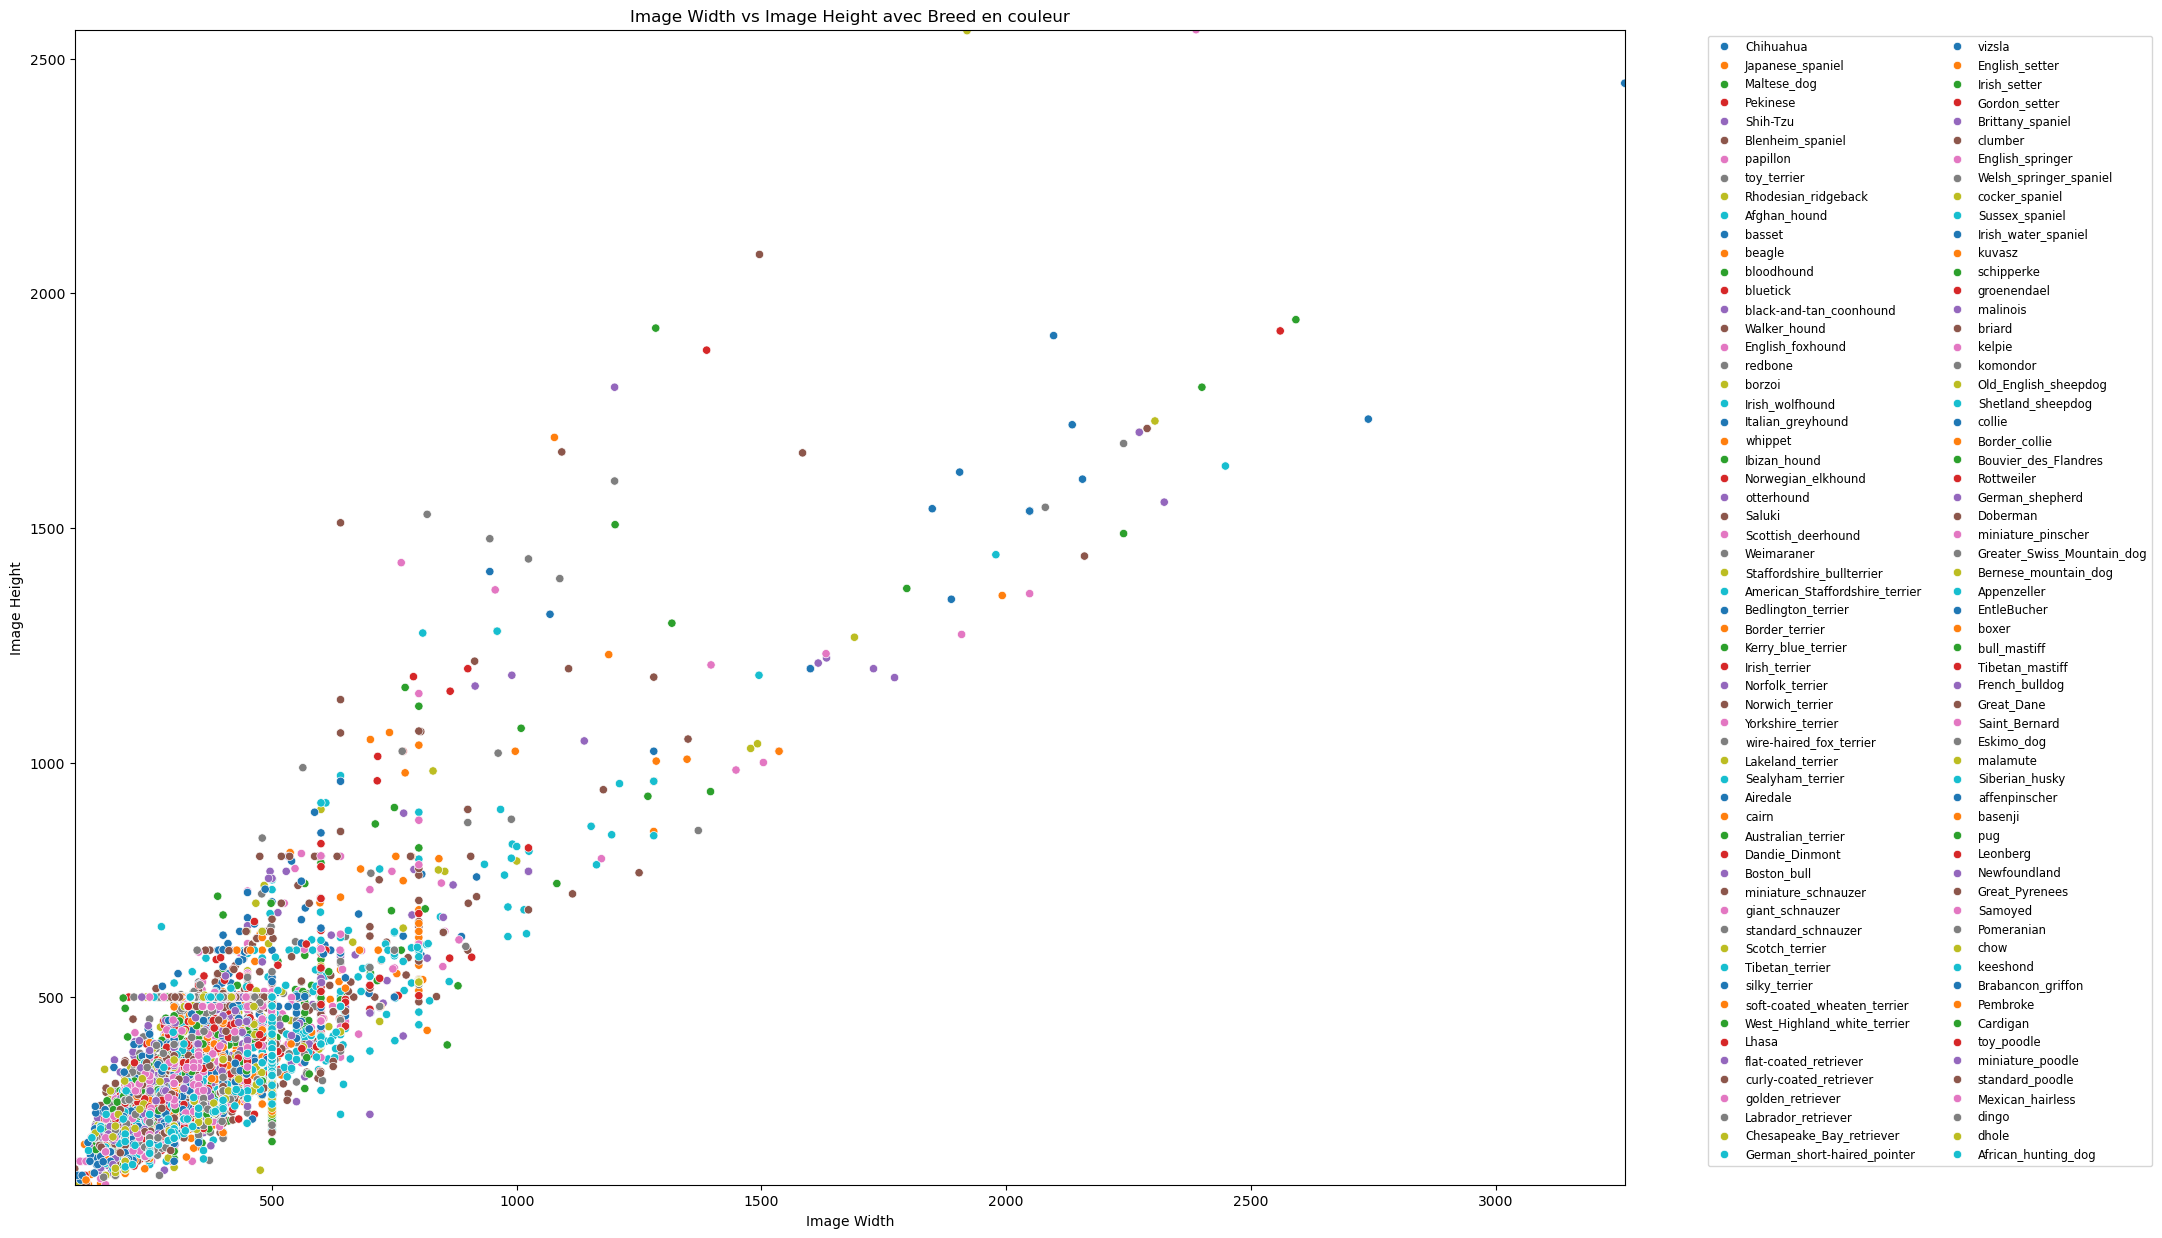

In [139]:
plt.figure(figsize=(20, 15))
sns.scatterplot(x='img_width', y='img_height', hue='breed', data=data_analysis, palette='tab10')
plt.xlabel('Image Width')
plt.ylabel('Image Height')
plt.xlim(data_analysis['img_width'].min(), data_analysis['img_width'].max())
plt.ylim(data_analysis['img_height'].min(), data_analysis['img_height'].max())
plt.title('Image Width vs Image Height avec Breed en couleur')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.show()

In [164]:
# Calcul du centre de l'image
data_analysis['center_x'] = data_analysis['img_width'] / 2
data_analysis['center_y'] = data_analysis['img_height'] / 2

# Calcul des coordonnées du point entre (xmin, ymin) et (xmax, ymax)
data_analysis['point_x'] = (data_analysis['xmin'] + data_analysis['xmax']) / 2
data_analysis['point_y'] = (data_analysis['ymin'] + data_analysis['ymax']) / 2

# Calcul de la distance entre le point et le centre de l'image
data_analysis['distance_to_center'] = np.sqrt((data_analysis['point_x'] - data_analysis['center_x'])**2 + 
                                              (data_analysis['point_y'] - data_analysis['center_y'])**2)

print(data_analysis[['breed', 'point_x', 'point_y', 'distance_to_center']].head())

       breed  point_x  point_y  distance_to_center
0  Chihuahua    150.5    254.0           16.492423
1  Chihuahua    221.0    251.0           23.759209
2  Chihuahua    238.5    146.5           11.768602
3  Chihuahua    156.0    262.5           20.700242
4  Chihuahua    166.0    278.0           36.345564


In [165]:
data_analysis.describe()

img_width    img_height  dog_trunc          xmin          ymin  \
count  20580.000000  20580.000000    20580.0  20580.000000  20580.000000   
mean     442.531876    385.861224        0.0     76.541011     56.541351   
std      142.792308    124.863446        0.0     75.279383     59.406210   
min       97.000000    100.000000        0.0      0.000000      0.000000   
25%      361.000000    333.000000        0.0     15.000000     13.000000   
50%      500.000000    375.000000        0.0     57.000000     39.000000   
75%      500.000000    453.000000        0.0    120.000000     82.000000   
max     3264.000000   2562.000000        0.0   1230.000000   1548.000000   

               xmax          ymax      center_x      center_y       point_x  \
count  20580.000000  20580.000000  20580.000000  20580.000000  20580.000000   
mean     365.581681    354.171283    221.265938    192.930612    221.061346   
std      129.140475    122.409322     71.396154     62.431723     83.899107   
min       71.000000     90.000000     48.500000     50.000000     37.500000   
25%      291.000000    289.000000    180.500000    166.500000    168.000000   
50%      359.000000    339.000000    250.000000    187.500000    219.500000   
75%      439.000000    399.000000    250.000000    226.500000    261.500000   
max     2735.000000   2457.000000   1632.000000   1281.000000   1885.500000   

            point_y  distance_to_center  
count  20580.000000        20580.000000  
mean     205.356317           42.309822  
std       75.268652           37.902739  
min       49.000000            0.000000  
25%      166.500000           14.150972  
50%      194.500000           31.668201  
75%      239.500000           59.610716  
max     2002.500000          772.888414

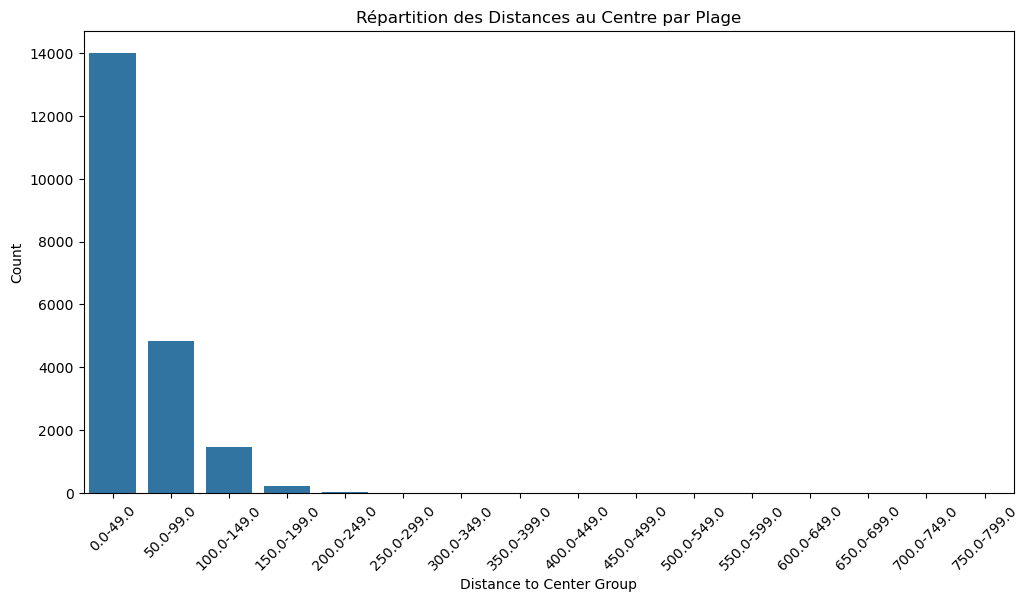

In [168]:
bin_size = 50

# Créer les bins
min_distance = data_analysis['distance_to_center'].min()
max_distance = data_analysis['distance_to_center'].max()
bins = np.arange(min_distance, max_distance + bin_size, bin_size)
labels = [f'{b}-{b + bin_size - 1}' for b in bins[:-1]]
data_analysis['distance_group'] = pd.cut(data_analysis['distance_to_center'], bins=bins, labels=labels, right=False)
distance_group_counts = data_analysis['distance_group'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=distance_group_counts.index, y=distance_group_counts.values)
plt.xlabel('Distance to Center Group')
plt.ylabel('Count')
plt.title('Répartition des Distances au Centre par Plage')
plt.xticks(rotation=45)
plt.show()

# Traitement de l'image

Taille actuelle :  (500, 333)
Taille resize :  (216, 216)


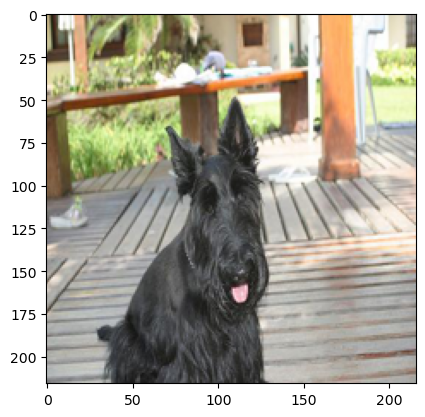

In [7]:
print("Taille actuelle : ", random_dogo.size)
resized_dogo = random_dogo.resize((216,216))
plt.imshow(resized_dogo)
print("Taille resize : ", resized_dogo.size)

./Datas/Images\n02107142-Doberman\n02107142_9597.jpg => 2 chiens sur la photo !

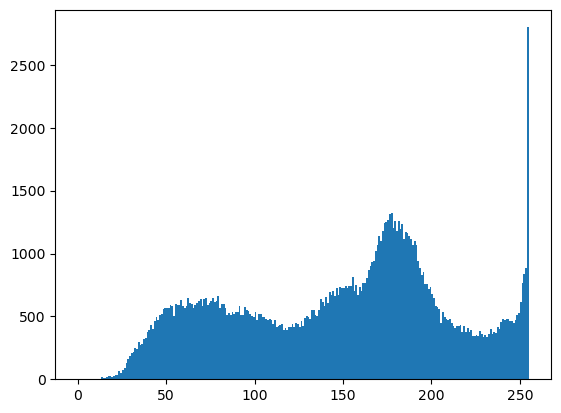

In [8]:
# Charger l'image comme matrice de pixels
img = np.array(resized_dogo)

# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(img.flatten(), bins=range(256))
plt.show()

## Fonction de manipulation des images

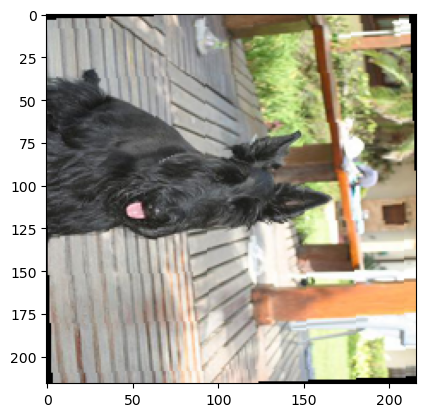

In [9]:
def apply_rotation_random(img):
    return img.rotate(random.randrange(-180, 180))

plt.imshow(apply_rotation_random(resized_dogo))

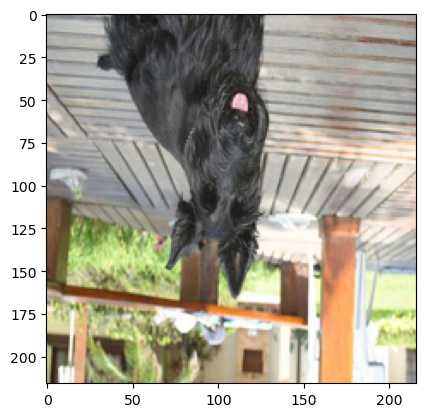

In [10]:
def apply_flip_random(img):
    return img.transpose(random.choice([Image.FLIP_LEFT_RIGHT, Image.FLIP_TOP_BOTTOM]))

plt.imshow(apply_flip_random(resized_dogo))

Taille actuelle :  (216, 216)


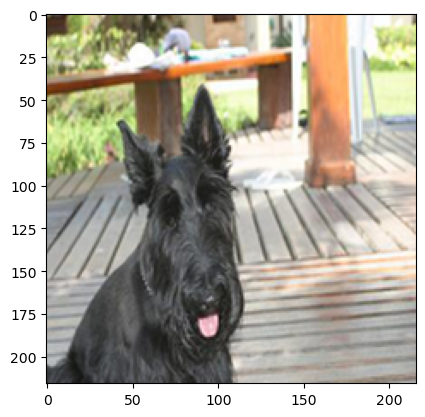

In [11]:
def apply_zoom_random(img, target_size=(216, 216), zoom_range=(0.8, 1)):
    # Taille actuelle de l'image
    width, height = img.size
    
    # Déterminer le facteur de zoom
    zoom_factor = random.uniform(*zoom_range)
    
    # Calculer les nouvelles dimensions de l'image zoomée
    new_width = int(width * zoom_factor)
    new_height = int(height * zoom_factor)
    
    # S'assurer que les nouvelles dimensions ne dépassent pas celles de l'image d'origine
    new_width = min(new_width, width)
    new_height = min(new_height, height)
    
    # Choisir aléatoirement les coordonnées du coin supérieur gauche du rectangle de zoom
    x1 = random.randint(0, width - new_width)
    y1 = random.randint(0, height - new_height)
    x2 = x1 + new_width
    y2 = y1 + new_height
    
    # Recadrer l'image zoomée pour revenir à la taille cible
    zoomed_img = img.crop((x1, y1, x2, y2))
    zoomed_img = zoomed_img.resize(target_size, Image.LANCZOS)    
    return zoomed_img

doggo_random_resized = apply_zoom_random(resized_dogo)
print("Taille actuelle : ", doggo_random_resized.size)
plt.imshow(doggo_random_resized)

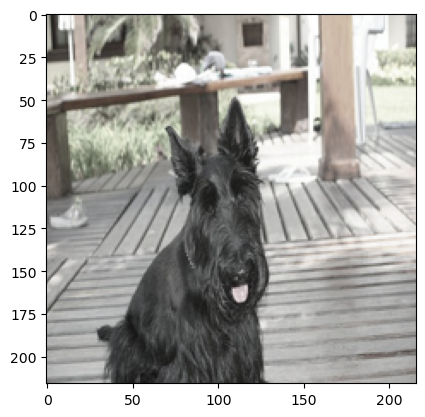

In [12]:
def apply_color_adjustment_random(img,max_colour=8):
    chosen_interval = random.choices([(0, 1), (1, max_colour)], weights=[0.5, 0.5])[0]
    factor =  random.uniform(chosen_interval[0], chosen_interval[1])
    return ImageEnhance.Color(img).enhance(factor)

plt.imshow(apply_color_adjustment_random(resized_dogo))

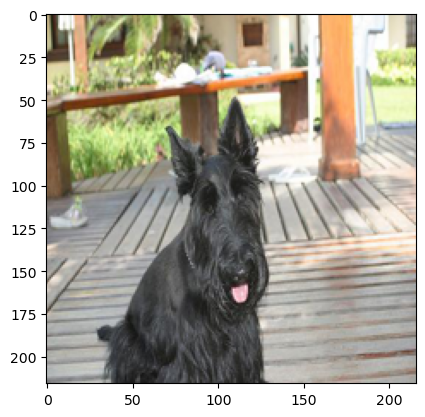

In [13]:
def apply_constrast_random(img,random=random.randint(1, 25)):
    return ImageEnhance.Sharpness(img).enhance(random)

plt.imshow(apply_constrast_random(resized_dogo))

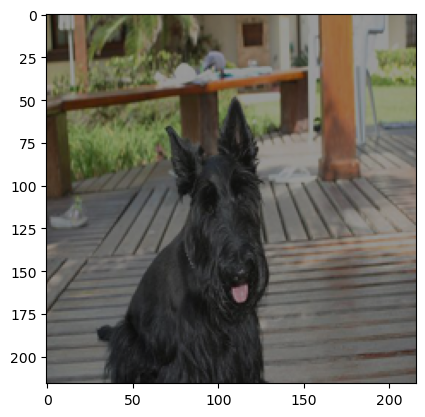

In [14]:
def apply_brightness_random(img,random=random.uniform(0.1, 0.9)):
    return ImageEnhance.Brightness(img).enhance(random)

plt.imshow(apply_brightness_random(resized_dogo))

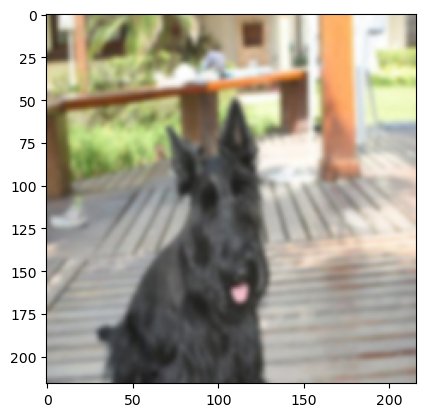

In [15]:
def apply_gaussian_blur_random(img,random=random.uniform(0, 2)):
    return img.filter(ImageFilter.GaussianBlur(random))

plt.imshow(apply_gaussian_blur_random(resized_dogo))

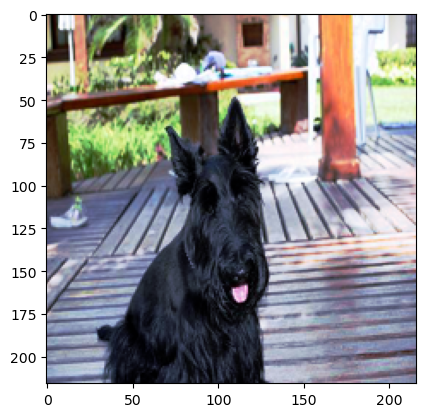

In [16]:
def apply_equalize_random(img,random=random.uniform(0, 2)):
    return ImageOps.equalize(img)

plt.imshow(apply_equalize_random(resized_dogo))

## Application aléatoire des manipulations

In [17]:
def weighted_random_choice(n):
    weights = np.linspace(n, 1, n) ** 2  # Crée une distribution avec des poids exponentiels décroissants
    #print(weights)
    weights = weights / weights.sum()
    return random.choices(range(1, n + 1), weights)[0]

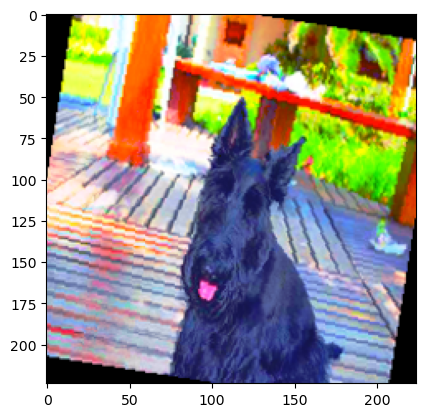

In [18]:
custom_image_functions = [
    apply_rotation_random,
    apply_flip_random,
    apply_zoom_random,
    apply_color_adjustment_random,
    apply_constrast_random,
    apply_brightness_random,
    apply_gaussian_blur_random,
    apply_equalize_random,
]

def apply_alteration_random(img,og_size=(224,224)):
    #num_functions = random.randint(1, len(custom_image_functions))
    num_functions = weighted_random_choice(len(custom_image_functions)+1)    

    if num_functions==0:
        return img
    
    modified_image = img.copy()
    for _ in range(num_functions):
        random_function = random.choice(custom_image_functions)
        modified_image = random_function(modified_image)    

    return modified_image.resize(og_size)

plt.imshow(apply_alteration_random(resized_dogo))

# Constitution d'un jeu de train/test

In [21]:
def get_dogs_picture_breed(images_dir= "./Datas/Images", annotations_dir= "./Datas/Annotation", output_size=(224, 224)):
    """
    Parcourt les répertoires d'images et d'annotations pour trouver les fichiers correspondants,
    redimensionne les images & leur applique aléatoirement des transformation + associe les données d'annotation.

    Args:
        images_dir (str): Chemin vers le répertoire contenant les dossiers des images /breed/"imagages .jpg"
        annotations_dir (str): Chemin vers le répertoire contenant les annotations /breed/"annotations"
        output_size (tuple): Taille de sortie pour le redimensionnement des images, par défaut les dimensions 224/224 sont celle de VGG16

    Returns:
        pd.DataFrame: DataFrame contenant les images et les données extraites des annotations.
    """
    data = []

    total_dirs = sum(1 for _ in os.walk(images_dir))

    with tqdm(total=total_dirs, desc="Processing directories") as pbar:
        for root, _, files in os.walk(images_dir):
            pbar.set_postfix(current_directory=root)

            for file in files:
                if file.endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(root, file)
                    rel_path = os.path.relpath(root, images_dir)
                    corresponding_xml_path = os.path.join(annotations_dir, rel_path, file)
                    corresponding_xml_path = corresponding_xml_path.replace('.png', '').replace('.jpg', '').replace('.jpeg', '')

                    if os.path.exists(corresponding_xml_path):
                        resized_image = resize_image(image_path, output_size)
                        altered = apply_alteration_random(resized_image)
                        data.append((img_to_array(altered), extract_data_from_annotation(corresponding_xml_path)["object/name"]))
    
            pbar.update(1)
    return pd.DataFrame(data, columns=['Image', 'Race'])


def resize_image(image_path, output_size):
    """
    Redimensionne l'image à la taille spécifiée.

    Args:
        image_path (str): Chemin vers l'image à redimensionner.
        output_size (tuple): Taille de sortie pour le redimensionnement de l'image.

    Returns:
        Image: Image redimensionnée.
    """
    with Image.open(image_path) as img:
        resized_img = img.resize(output_size)
        return resized_img

In [169]:
# Création du DataFrame
datas = get_dogs_picture_breed()

# Affichage du DataFrame
#print(datas)

Processing directories:  26%|██▋       | 32/121 [00:37<01:44,  1.17s/it, current_directory=./Datas/Images\n02093754-Border_terrier]                


KeyboardInterrupt: 